# Seq2seq with attention model을 적용한 뉴스 요약봇 만들기

# 개념 정리

- Extractive Summarization : 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용 - 네이버 뉴스- 요약봇 TextRank 알고리즘 사용,문장 분류(Text Classification)

- Abstractive Summarization : 원문으로부터 내용이 요약된 새로운 문장을 생성(자연어 생성(Natural Language Generation, NLG)의 영역), RNN은 학습데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어려움

## seq2seq model
: 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델
 
- 각각 Encoder , Decoder로 불리는 2개의 RNN으로 구성하며, sequence(문장)을 입력으로 받고, 입력이 끝나면 sequence를 출력함.
- Encoder: 입력문장을 받는 RNN, 
- Decoder : 생성 혹은 예측된 문장을 출력하는 RNN
- 실제 성능 문제로 Vanilla RNN보다는 LSTM , GRU로 구성
- Encoder는 모든 입력문장을 input으로 받은 후, Encoder에서의 맨 마지막 step의 hidden state(context vector, 이 입력문장들이 잘 압축 또는 요약된 정보)들을 Decoder에 넘겨줌., Decoder에서는 context vector를 받아 첫번째 hidden state로 사용
- Encoder서는 첫번째 hidden state를 0으로 초기화해 사용, Decoder에서는 Encoder부터 받은 context vector를 첫번째 hidden state로 사용
- seq2seq는 end-to-end로 학습으로 Encoder에서부터 하나하나 순차적으로 진행
- Backpropagation이 진행될 때도, Encoder의 1번째 step까지 가려면 엄청나게 먼 길을 걸어와야 함. -> Gradient vanishing 초래함.

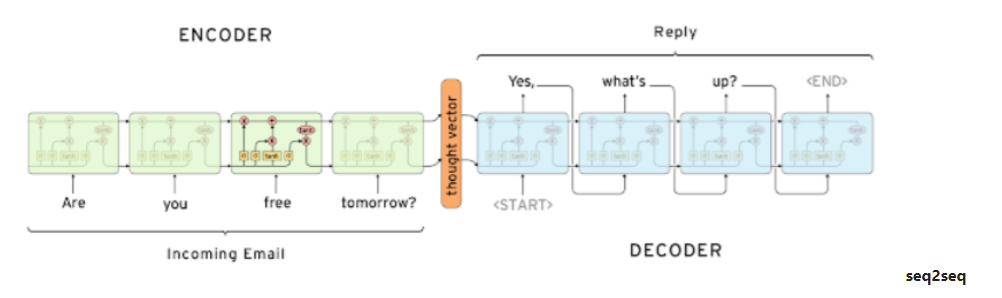

## seq2seq with attention

- Attention의 기본 아이디어 : Enncoder에서의 각 timestep에서의 hidden state를  Decoder가 다음 단어를 예측할 때 참고하는 것
- Encoder에서 각 timeste마다 출력되는 hidden state를 concat해 따로 기억해준 후seq2seq와 똑같이 context vector를 Decoder에 넘겨줌.
- Decoder에서는 다음 단어를 예측할 때 context vector와 concat한 hidden state를 통해 집중해야되는 source sequence부분 2가지를 이용함.

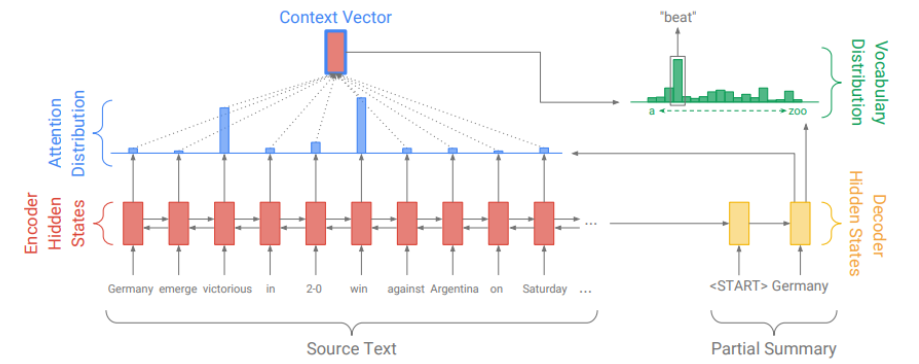

# 루브릭

1.분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2.모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.

3.두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.



# seq2seq model 사용방법

1. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 함.
2. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙임.
3. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작하게 됨
4. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산함
5. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측하게 됨.

# Step 1. 라이브러리 임포트 및 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
87742,"Ã¢ÂÂ¹10,000 cr transacted in IPL betting in B...","As per reports, betting worth almost Ã¢ÂÂ¹10,..."
93137,Censor Board is bound by old-fashioned laws: R...,Actress Raveena Tandon has said that the Centr...
67432,"Wear Guj glasses, not Italian to see progress:...",BJP President Amit Shah took a jibe at Congres...
83984,Artificial intelligence could start World War ...,Chinese e-commerce giant Alibaba's billionaire...
65021,9 killed as part of state transport building c...,As many as nine crew members were killed after...
50821,Grocery delivery startup Milkbasket raises Ã¢Â...,Gurugram-based grocery delivery startup Milkba...
11740,Kill us all: Kin of martyred J&K policeman to ...,A Facebook post purportedly shared by a family...
17425,Visited UK as tourists: Russians accused of po...,The two Russian nationals accused of poisoning...
68061,"Karnataka bans sale of loose cigarettes, beedis",Karnataka government has banned the sale of lo...
73359,Right to Privacy to not affect Aadhaar-PAN lin...,The 'Right to Privacy' verdict will have no be...


# Step 2. 데이터 전처리하기 (추출적 요약)

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있음,
추출적 요약은 text열 만을 사용할 것임.

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
#drop_duplicates()가 중복된 Null들을 지워줌
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈.
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
#데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화(text normalization)

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어(stopwords) 제거, 모든 영어문자 소문자 변환, html 및 특수 문자제거

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
#전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines를 만들어 함수를 호출
temp_text = 'Scientists have detected radio signals from <br />for my mother and father.'
temp_headlines = 'Designer reveals she was offered fake print of'
print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않음.

text:  scientists detected radio signals mother father
headlines: designer reveals she was offered fake print of


In [11]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있음. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []
# 전체 헤드라인 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있음. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
#텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인
#빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# null 값이 생겻는지 확인
data.isnull().sum()


headlines    0
text         0
dtype: int64

### 훈련데이터와 테스트데이터 나누기

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 함.

#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


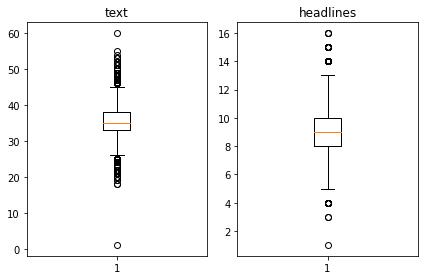

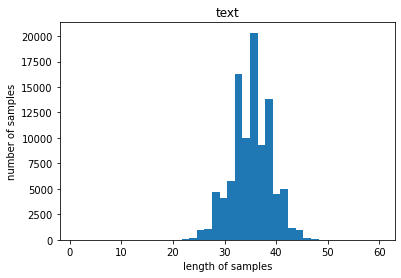

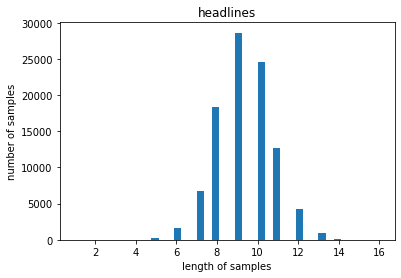

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있음

text의 경우 최소 길이가 1, 최대 길이가 60으로 그 차이가 좀 있음. 하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 30~40 내외의 길이를 가진다는 것을 확인할 수 있음.

headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 text에 비해 상대적으로 길이가 매우 짧음. 그래프로 봤을 때에도 대체적으로 8~10의 길이를 가지고 있음.

In [15]:
# Text의 최대 길이 임의로 지정
text_max_len = 60
headlines_max_len = 15

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


각각 60과 15로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 됨

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단할 것임

In [16]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


#### 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

In [17]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98357


### 시작 토큰과 종료 토큰 추가하기

시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 것임.

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정하고 두 개의 문장 모두 Summary 열로부터 만들 거임

In [18]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [20]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[22970 88262 79524 ... 87976 10698 91038]


In [21]:
#우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줌
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21800  1007 97813 ... 64972 12607 65722]


In [22]:
# 위 정수 시퀀스를 이용하여 다시 데이터의 샘플 순서를 정의
#하면 잘 섞인 샘플이 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
#데이터를 분리하기 위해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19671


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분함. 

:표시의 위치에 주의

In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78686
훈련 레이블의 개수 : 78686
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야하고 이를 위해서 각 단어에 고유한 정수를 맵핑하는 작업이 피요함. 이 과정을 단어 집합(vocabulary)을 만든다고 표현함.

keras의 tokenizer를 사용하여 입력된 훈련데이터로부터 단어집합을 형성할 수 있음.(src_tokenizer.word_index에 저장)

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있음

#### 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69635
등장 빈도가 6번 이하인 희귀 단어의 수: 47463
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22172
단어 집합에서 희귀 단어의 비율: 68.15968981115819
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.490731285652904


등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지함 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.49%밖에 되지 않음

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 함.

위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해봄

토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있음

In [27]:
src_vocab = 8000 # 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2054, 661, 1260, 172, 926, 805, 449, 867, 2961, 1026, 328, 87, 92, 2961, 7, 4022, 17, 25, 1340, 1840, 1686, 3, 577, 604, 1260, 172, 328, 29, 590, 199, 820, 2961, 2061, 1667], [227, 298, 952, 25, 1498, 34, 251, 3213, 1115, 1936, 4785, 3363, 124, 752, 124, 598, 7271, 320, 31, 3450, 833, 3337, 659, 1869, 2442, 7271, 1498, 251, 3377, 427, 26, 227, 1], [3364, 1853, 288, 4198, 4250, 3707, 4046, 2577, 851, 371, 4281, 73, 162, 87, 2577, 2165, 436, 7899, 382, 782, 6131, 6132, 288, 4198, 315, 371, 2157, 162]]


In [29]:
# summary데이터에 대해서도 동일한 작업 적용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30090
등장 빈도가 5번 이하인 희귀 단어의 수: 19694
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10396
단어 집합에서 희귀 단어의 비율: 65.45031571950814
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.677492813493968


encoder_input_train에는 3만여 개의 단어가 있다.
등장 빈도가 threshold 값인 6회 미만, 즉 5회 이하인 단어들은 단어 집합에서 무려 65% 이상을 차지
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.6%밖에 되지 않는다.
그래서 등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
위에서 이를 제외한 단어 집합의 크기를 10,000개로 계산

In [31]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2010, 547, 3, 20, 427, 4, 36, 361, 233, 6496, 4, 98], [1, 38, 437, 82, 469, 7235, 4256, 5039, 7672, 3, 149], [1, 2353, 153, 2796, 278, 1550, 6, 1003, 53], [1, 9530, 3903, 1004, 3505, 796, 3, 247, 276, 231, 2437], [1, 5432, 4522, 3, 5223, 1207, 7, 4016]]
target
decoder  [[2010, 547, 3, 20, 427, 4, 36, 361, 233, 6496, 4, 98, 2], [38, 437, 82, 469, 7235, 4256, 5039, 7672, 3, 149, 2], [2353, 153, 2796, 278, 1550, 6, 1003, 53, 2], [9530, 3903, 1004, 3505, 796, 3, 247, 276, 231, 2437, 2], [5432, 4522, 3, 5223, 1207, 7, 4016, 2]]


In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78685
훈련 레이블의 개수 : 78685
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있음

길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높음

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아옴.

여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않음 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나옴. (길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있기 때문)

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 이 샘플들은 모두 삭제

### 패딩하기

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')


## 모델 설계하기

(1) 인코더

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 #  LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였음. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있음.


(2) 디코더 설계

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일함. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야함.

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 함.

그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 함

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

텐서플로우에 이미 구현된 어텐션함수를 가져와 디코더의 출력층에 결합할려고 함

In [37]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있음

## 모델 훈련하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 264s 828ms/step - loss: 4.5482 - val_loss: 4.1637
Epoch 2/50
308/308 [==============================] - 254s 824ms/step - loss: 4.0344 - val_loss: 3.8773
Epoch 3/50
308/308 [==============================] - 256s 830ms/step - loss: 3.7851 - val_loss: 3.6853
Epoch 4/50
308/308 [==============================] - 254s 824ms/step - loss: 3.5870 - val_loss: 3.5382
Epoch 5/50
308/308 [==============================] - 253s 823ms/step - loss: 3.4214 - val_loss: 3.3994
Epoch 6/50
308/308 [==============================] - 253s 822ms/step - loss: 3.2844 - val_loss: 3.3161
Epoch 7/50
308/308 [==============================] - 252s 819ms/step - loss: 3.1699 - val_loss: 3.2495
Epoch 8/50
308/308 [==============================] - 255s 829ms/step - loss: 3.0732 - val_loss: 3.1819
Epoch 9/50
308/308 [==============================] - 252s 818ms/step - loss: 2.9881 - val_loss: 3.1373
Epoch 10/50
308/308 [==============================] - 252s 817m

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정한다는 뜻임.

EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있음

### 모델평가

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 됨.

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해야됨.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했음

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함. 이때는 인코더 모델과 디코더 모델을 분리해서 설계함.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 형성
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트하기

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만듬
함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 함

# Step 4. 실제 결과와 요약문 비교하기 

### 1. Abstractive Summarization

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

# Step 5. Summa을 이용해서 추출적 요약해보기

In [ ]:
import requests
from summa.summarizer import summarize

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data['text'].sample(10)

####  summarize()의 인자

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [ ]:
for i in range(10):
    print(i+1, "-------------------------------------------------------")
    print("원문 :", data['text'][i])
    print("\n")
    print("실제 요약 :", data['headlines'][i])
    print("추출적 요약(ratio) :", summarize(data["text"][i], ratio=0.5))
    print("추출적 요약(words) :", summarize(data["text"][i], words=20))
    print("\n")

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행함. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음. 

원문의 0.005%만을 출력하도록 설정함.

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

In [ ]:
print('Summary:')
print(summarize(text, words=50))

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높음. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮음

# Report



앞서 seq2seq를 통한 추상적 요약과 패키지 summa를 활용해 추출적 요약을 실습해보았음.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있었음.

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져 올 수 있었으나, 표현이 어색하게 표현될 수 있는 반면에, 추출적 요약은 말 그대로 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약으로 나올 가능성이 낮은 것을 확인 할 수 있었음.

추출적 요약의 단점으로는 중요한 상위 몇개의 문장들만 뽑아낸거지, 이 문장들이 전체 내용을 요약해준 것은 아니다는 점임.